In [138]:
from pathlib import Path
from collections import namedtuple
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score

sb.set()

In [139]:
logs = Path("/home/jeroen/Documents/Studie/Capita/logs/csv_only/final")
categories = ['Full', 'Wrist', 'Shoulder', 'Humerus']
models = ['single', 'fusion-mean', 'fusion-mean-post', 'dd-mean', 'dd-mean-std', 'dd-mean-tanh', 'dd-mean-std-tanh']
folds = list(range(7))

In [140]:
def get_prediction_df():
    df = None
    for category in categories:
        for model in models:
            for fold in [f'fold_{f}' for f in folds]:
                csv = logs / category / model / fold / 'test_predictions.csv'
                
                if csv.exists():
                    d = pd.read_csv(csv)
                    d['_img_files'] = d['_img_files'].apply(lambda x: x[1:-1].split(', '))
                    d['img_count'] = d['_img_files'].str.len()
                    d = d[['location', 'folder', 'img_count', 'label', 'prediction']]

                    d['category'] = category
                    d['model'] = model
                    d['fold'] = fold

                    if df is None:
                        df = d
                    else:
                        df = pd.concat([df, d])
    
    df = df.groupby(['category', 'model', 'folder', 'location', 'img_count', 'label']).agg(prediction=('prediction', 'mean')).reset_index()
    return df

df = get_prediction_df()
df

,category,model,folder,location,img_count,label,prediction
0,Full,dd-mean,test/XR_ELBOW/patient11186/study1_positive,Elbow,5,1,0.949475
1,Full,dd-mean,test/XR_ELBOW/patient11189/study1_positive,Elbow,4,1,0.891815
2,Full,dd-mean,test/XR_ELBOW/patient11204/study1_negative,Elbow,2,0,0.083793
3,Full,dd-mean,test/XR_ELBOW/patient11205/study1_negative,Elbow,3,0,0.121775
4,Full,dd-mean,test/XR_ELBOW/patient11217/study1_negative,Elbow,3,0,0.353365
...,...,...,...,...,...,...,...
12350,Wrist,single,test/XR_WRIST/patient11387/study1_negative,Wrist,3,0,0.378313
12351,Wrist,single,test/XR_WRIST/patient11388/study1_negative,Wrist,3,0,0.230261
12352,Wrist,single,test/XR_WRIST/patient11389/study1_negative,Wrist,3,0,0.262848
12353,Wrist,single,test/XR_WRIST/patient11390/study1_negative,Wrist,4,0,0.247062


In [141]:
df['count_group'] = df['img_count'].apply(lambda x: str(x) if x <= 4 else '5+')
df['pred'] = df['prediction'].apply(lambda x: int(round(x)))

def kappa(g):
    return pd.DataFrame({'kappa': [cohen_kappa_score(g['label'], g['pred'], labels=[0, 1])]})

# Per dataset visualization

In [142]:
gdf = df.groupby(['model', 'category', 'count_group']).apply(kappa)

/home/jeroen/.miniconda3/envs/capita/lib/python3.6/site-packages/sklearn/metrics/_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


In [143]:
t = gdf.reset_index()
t[t['kappa'].isna()]

,model,category,count_group,level_3,kappa
9,dd-mean,Humerus,5+,0,NaN
29,dd-mean-std,Humerus,5+,0,NaN
49,dd-mean-std-tanh,Humerus,5+,0,NaN
69,dd-mean-tanh,Humerus,5+,0,NaN
89,fusion-mean,Humerus,5+,0,NaN
109,fusion-mean-post,Humerus,5+,0,NaN
129,single,Humerus,5+,0,NaN


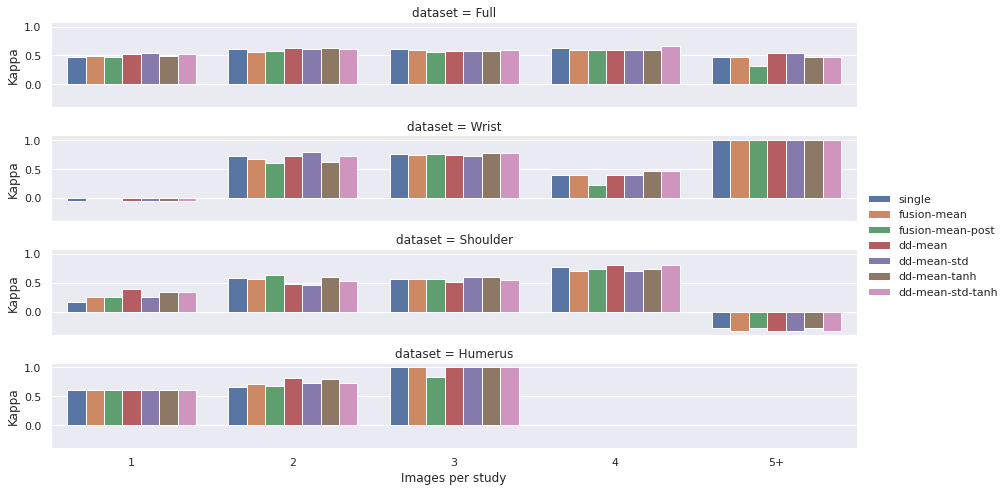

In [145]:
tmp = gdf.reset_index()
tmp['dataset'] = tmp['category']
g = sb.FacetGrid(tmp, row='dataset', row_order=categories, aspect=7, height=1.75)
g.map_dataframe(sb.barplot, x='count_group', y='kappa', hue='model', hue_order=models, palette=sb.color_palette())
g.set_axis_labels('Images per study', 'Kappa')
plt.tight_layout()
g.add_legend()
plt.savefig('pa_1.png', dpi=300)

# Per category visualization

In [132]:
gdf = df[df['category'] == 'Full'].groupby(['model', 'location', 'count_group']).apply(kappa).reset_index()

/home/jeroen/.miniconda3/envs/capita/lib/python3.6/site-packages/sklearn/metrics/_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


In [133]:
gdf[gdf['kappa'].isna()]

,model,location,count_group,level_3,kappa
9,dd-mean,Finger,5+,0,NaN
19,dd-mean,Hand,5+,0,NaN
24,dd-mean,Humerus,5+,0,NaN
44,dd-mean-std,Finger,5+,0,NaN
54,dd-mean-std,Hand,5+,0,NaN
59,dd-mean-std,Humerus,5+,0,NaN
79,dd-mean-std-tanh,Finger,5+,0,NaN
89,dd-mean-std-tanh,Hand,5+,0,NaN
94,dd-mean-std-tanh,Humerus,5+,0,NaN
114,dd-mean-tanh,Finger,5+,0,NaN


In [134]:
gdf[gdf['location'] == 'Elbow']

,model,location,count_group,level_3,kappa
0,dd-mean,Elbow,1,0,1.000000
1,dd-mean,Elbow,2,0,0.529274
2,dd-mean,Elbow,3,0,0.532609
3,dd-mean,Elbow,4,0,0.829787
4,dd-mean,Elbow,5+,0,0.000000
35,dd-mean-std,Elbow,1,0,1.000000
36,dd-mean-std,Elbow,2,0,0.544734
37,dd-mean-std,Elbow,3,0,0.483311
38,dd-mean-std,Elbow,4,0,0.829787
39,dd-mean-std,Elbow,5+,0,0.000000


**mark unavailable datapoints with a red cross**

In [135]:
tmp = gdf.reset_index()
tmp = tmp[tmp['location'].isin(['Wrist', 'Shoulder', 'Humerus'])]

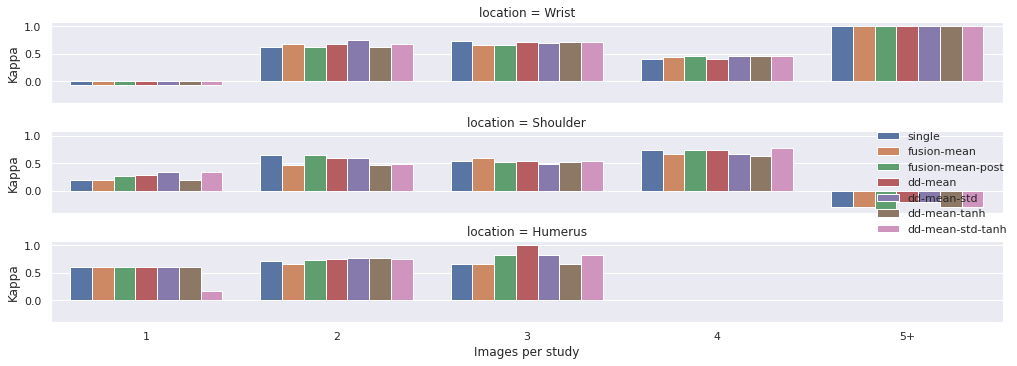

In [136]:
g = sb.FacetGrid(tmp, row='location', aspect=7, height=1.75, row_order=categories[1:])
g.map_dataframe(sb.barplot, x='count_group', y='kappa', hue='model', hue_order=models, palette=sb.color_palette())
g.add_legend()
g.set_axis_labels('Images per study', 'Kappa')
plt.tight_layout()
plt.savefig('pa_2.png', dpi=300)